# Quartz fertility analysis of mixing scenarios associated with the Mataquito River
##### This notebook calculates fertilites of quartz based on the erosion rates and their associated uncertainties using a monte carlo simulation of 100,000 samplings.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import rasterio
import csv
from rasterio.plot import show
from geopy.distance import geodesic

### Figure: Location of sampling points for ordering

Hillshade loaded successfully


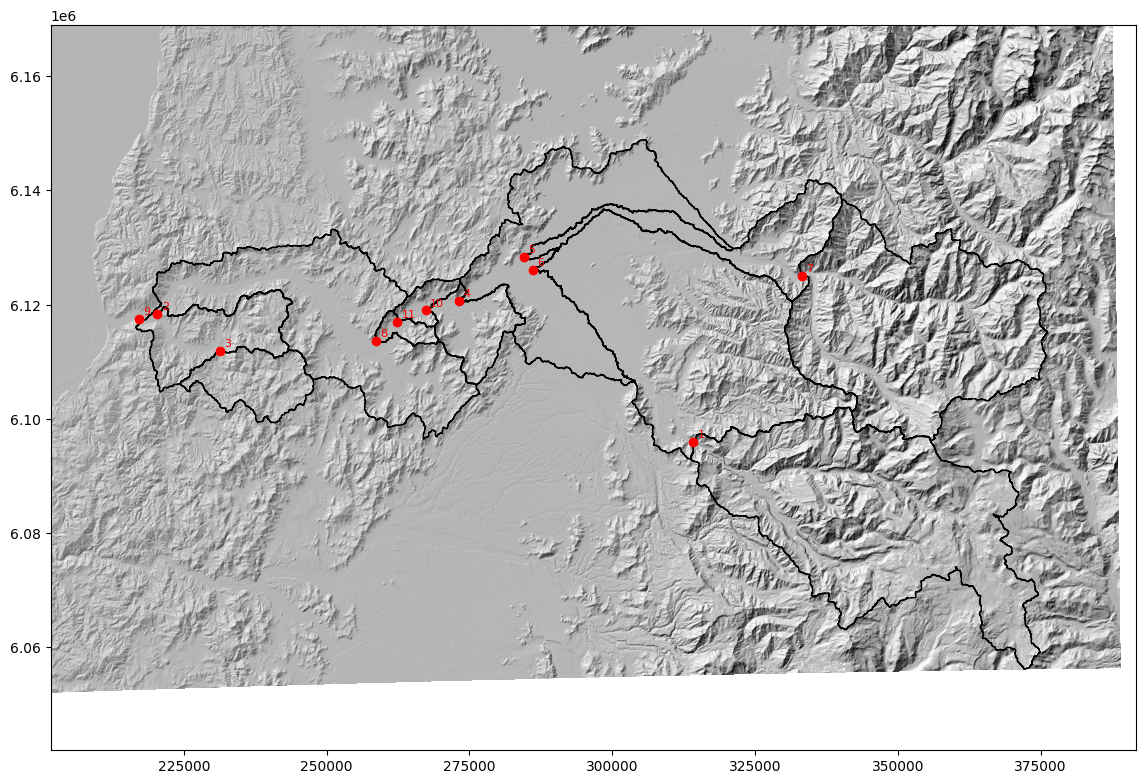

In [2]:
# loading in reference figure of samples
# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Set bounds based on your coordinates
x_coords = [201707, 391646, 286002, 307351]
y_coords = [6117461, 6095743, 6042001, 6168995]
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# load samples
samples = '/Users/Glong1/Desktop/Andes/Andes_watersheds/MataquitoRiver/mataquitosamplepoints_corrected_for_flow_30mDEM.shp'
samples_gdf = gpd.read_file(samples)
samples_gdf.plot(ax=ax, color='red', zorder=1000)
# Add ID labels to each point
for idx, row in samples_gdf.iterrows():
    x, y = row.geometry.x, row.geometry.y
    label = row['id']
    ax.annotate(str(label), (x, y), xytext=(3, 3), textcoords='offset points', 
                fontsize=8, ha='left', color='red', zorder=1000)

# Load and display hillshade
hillshade_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/MataquitoRiver/30DEMwatersheddata/Hillshade30m.tif'
with rasterio.open(hillshade_path) as src:
    show(src, ax=ax, cmap='gray', alpha=1.0)
print("Hillshade loaded successfully")

"""# load dem
dem_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/MataquitoRiver/30DEMwatersheddata/dem_utm30m.tif'
with rasterio.open(dem_path) as src:
    show(src, ax=ax, cmap='gray', alpha=1.0)
print("dem loaded successfully")"""

# Load and overlay the watershed boundary
watershed_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/MataquitoRiver/30DEMwatersheddata/mergedsubwatersheds.shp'
watershed_gdf = gpd.read_file(watershed_path)
watershed_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

plt.show()

### Loading in all relavant Mataquito River sample data from the MataquitoSampleData.xlsx sheet

In [3]:
# Load your Excel file into a DataFrame 
df = pd.read_excel('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/MataquitoSampleData.xlsx') 

# Print the DataFrame to display its contents
print(df)

   Sample_ID Sample_Type   Latitude  Longitude  Source_Area  Elevation  \
0       CT-1  river sand -35.261470 -71.042330     1385.185        550   
1       CT-2  river sand -35.038830 -72.067050     5760.128         11   
2       CT-3  river sand -35.100380 -71.946720      189.205         18   
3       CT-4  river sand -35.027690 -71.487020     4706.717        111   
4       CT-5  river sand -34.962640 -71.359940     1495.897        155   
5       CT-6  river sand -34.984880 -71.342700     2573.245        158   
6       CT-7  river sand -35.003550 -70.827530     1207.810        631   
7       CT-8  river sand -35.092222 -71.647745     4950.395         78   
8       CT-9  river sand -35.046389 -72.101111     6189.716          9   
9      CT-10  river sand -35.049444 -71.550000     4864.942        102   
10     CT-11  river sand -35.064167 -71.610278     4913.334         89   

    Virtual_Elevation  Surface_Production_Rate  Shielding_Factor  Quartz  \
0             2261.20              

### Setting random seed for reproducibility

In [4]:
 np.random.seed(17) # random seed set to arbitrary number

In [5]:
# config random sampling
number_samples = 100000

### Modeling erosion rates based on their uncertainties (subwatershed erosion rates)
#### Array erosion_samples stores all 100,000 random sampling of each samples erosion rate. Output print is the mean erosion rate with one standard deviation uncertainty

In [6]:
np.random.seed(17)
# Creating erosion rate samples for all sample sites
print("Modeled Erosion Rates based on monte carlo simulations")
# Create dictionary to store samples for each site
erosion_samples = {}
# Loop through all CT sites
for i in range(len(df)):
    site_name = f"CT-{i+1}"
    # Generate samples for this site
    samples = np.random.normal(df.loc[i, 'Erosion_rate'], 
                              df.loc[i, 'Erosion_rate_uncertainty_external'], 
                              number_samples)
    # Store samples in dictionary
    erosion_samples[site_name] = samples
    
    # Print results
    print(f"{site_name}: {np.mean(samples):6.4f} ± {np.std(samples):6.4f}")

Modeled Erosion Rates based on monte carlo simulations
CT-1: 22.8970 ± 1.8595
CT-2: 94.8280 ± 7.7192
CT-3: 29.5005 ± 2.4127
CT-4: 29.6065 ± 2.4398
CT-5: 387.0293 ± 31.8875
CT-6: 29.8014 ± 2.4379
CT-7: 532.1582 ± 51.9161
CT-8: 262.9688 ± 22.8529
CT-9: 104.9959 ± 8.5575
CT-10: 245.8567 ± 21.3102
CT-11: 286.0604 ± 24.5662


In [7]:
# calling the array of random sampling of 100,000 erosion rates
CT_1_samples = erosion_samples['CT-1']
CT_2_samples = erosion_samples['CT-2']
CT_3_samples = erosion_samples['CT-3']
CT_4_samples = erosion_samples['CT-4']
CT_5_samples = erosion_samples['CT-5']
CT_6_samples = erosion_samples['CT-6']
CT_7_samples = erosion_samples['CT-7']
CT_8_samples = erosion_samples['CT-8']
CT_9_samples = erosion_samples['CT-9']
CT_10_samples = erosion_samples['CT-10']
CT_11_samples = erosion_samples['CT-11']

### Flux ordered pairs
#### Setting the flux ordered pairs for the samples so there is no case where the flux is greater upstream than downstream. 

Success Fraction of Samples: 0.2100
Modeled Erosion Rates based on monte carlo simulations flux ordered
CT-7: 475.4129 ± 37.1232
CT-5: 413.5117 ± 27.1491
CT-7, CT-5 correlation: 0.6243


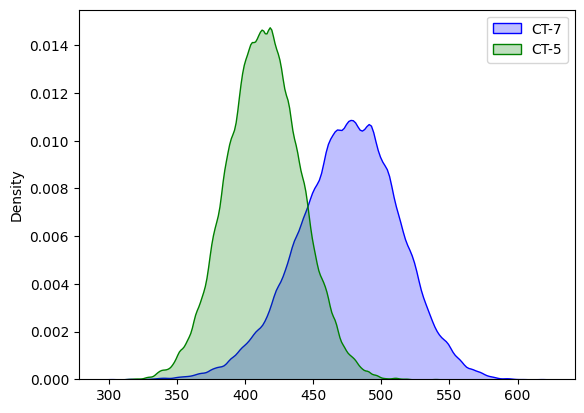

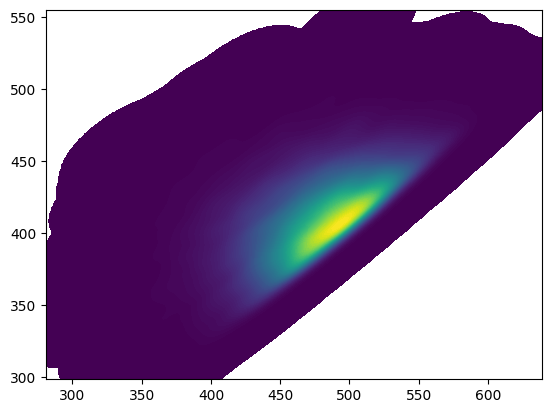

In [8]:
# Flux ordered pair 5 and 7 reference figure above for sample locations

# keeping random seed consistent
np.random.seed(17)
# Flux ordering CT-7 and CT-5:
flux_7 = df.loc[6, 'Source_Area'] * CT_7_samples
flux_5 = df.loc[4, 'Source_Area'] * CT_5_samples
i1 = np.where(flux_5 > flux_7)

plt.figure()
sns.kdeplot(CT_7_samples[i1], bw_adjust=.5, fill=True, color="blue", label="CT-7")
sns.kdeplot(CT_5_samples[i1], bw_adjust=.5, fill=True, color="green", label="CT-5")
plt.legend()

plt.figure()
sns.kdeplot(x=CT_7_samples[i1], y=CT_5_samples[i1], fill=True, thresh=0, levels=100, cmap="viridis")

print("Success Fraction of Samples: {0:6.4f}".format(i1[0].size / number_samples))
print("Modeled Erosion Rates based on monte carlo simulations flux ordered")
print("CT-7: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_7_samples[i1]), np.std(CT_7_samples[i1])))
print("CT-5: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_5_samples[i1]), np.std(CT_5_samples[i1])))
print("CT-7, CT-5 correlation: {0:6.4f}".format(np.corrcoef(CT_7_samples[i1], CT_5_samples[i1])[0,1]))

Success Fraction of Samples: 1.0000
Modeled Erosion Rates based on monte carlo simulations flux ordered
CT-1: 22.8970 ± 1.8595
CT-6: 29.8014 ± 2.4379
CT-1, CT-6 correlation: 0.0053


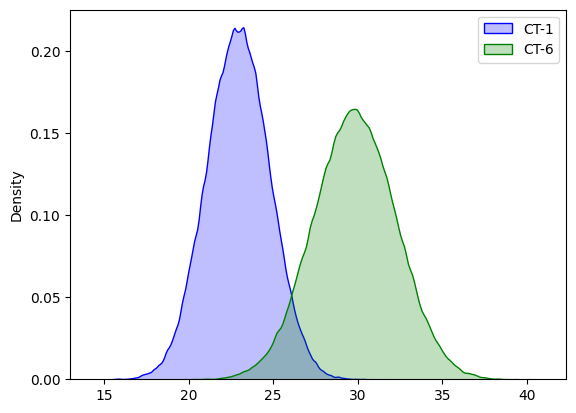

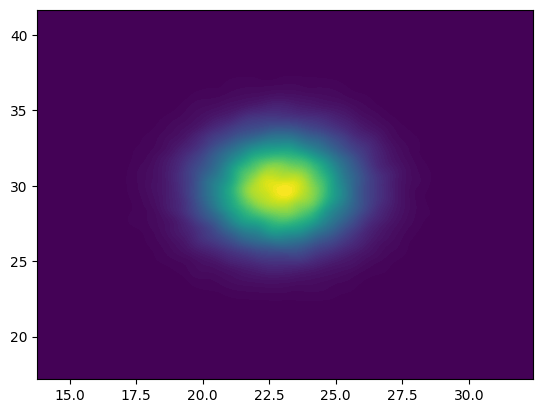

In [9]:
# Flux ordered pair 1 and 6 reference figure above for sample locations

np.random.seed(17)
# Flux ordering CT-1 and CT-6:
flux_1 = df.loc[0, 'Source_Area'] * CT_1_samples
flux_6 = df.loc[5, 'Source_Area'] * CT_6_samples
i2 = np.where(flux_6 > flux_1)

plt.figure()
sns.kdeplot(CT_1_samples[i2], bw_adjust=.5, fill=True, color="blue", label="CT-1")
sns.kdeplot(CT_6_samples[i2], bw_adjust=.5, fill=True, color="green", label="CT-6")
plt.legend()

plt.figure()
sns.kdeplot(x=CT_1_samples[i2], y=CT_6_samples[i2], fill=True, thresh=0, levels=100, cmap="viridis")

print("Success Fraction of Samples: {0:6.4f}".format(i2[0].size / number_samples))
print("Modeled Erosion Rates based on monte carlo simulations flux ordered")
print("CT-1: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_1_samples[i2]), np.std(CT_1_samples[i2])))
print("CT-6: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_6_samples[i2]), np.std(CT_6_samples[i2])))
print("CT-1, CT-6 correlation: {0:6.4f}".format(np.corrcoef(CT_1_samples[i2], CT_6_samples[i2])[0,1]))

### Quartz fertilities using flux ordered 

Modeled Erosion Rates based on monte carlo simulations flux ordered
CT-5: 387.0293 ± 31.8875
CT-6: 29.8014 ± 2.4379
Qb/Qa Fertility Ratio (mean, (25-75% range)): 0.2321 (0.1418 - 0.3081)
Qb/Qa Fertility Ratio (median, (25-75% range)): 0.2198 (0.1418 - 0.3081)
Qa/Qb: 11.8495 (3.2457 - 7.0537)
Qa/Qb: 4.5501 (3.2457 - 7.0537)


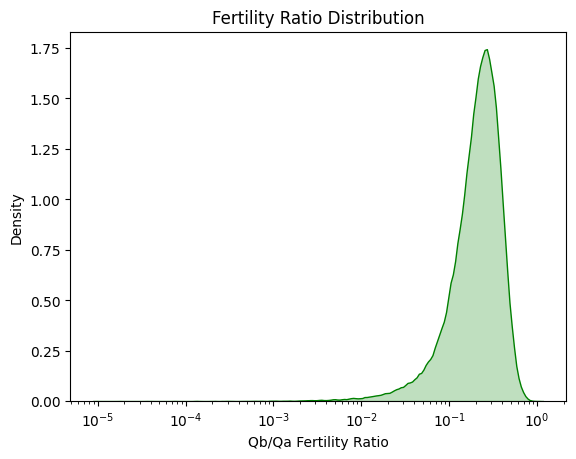

In [10]:
# Flux ordered using CT-5 and CT-6 to mix and form CT-10 with calculated fertilities.

np.random.seed(17)

# CT-5 and CT-6:
flux_7 = df.loc[6, 'Source_Area'] * CT_7_samples
flux_5 = df.loc[4, 'Source_Area'] * CT_5_samples
i3 = np.where(flux_5 > flux_7)
CT_5_ordered = CT_5_samples[i3]

flux_1 = df.loc[0, 'Source_Area'] * CT_1_samples
flux_6 = df.loc[5, 'Source_Area'] * CT_6_samples
i4 = np.where(flux_6 > flux_1)
CT_6_ordered = CT_6_samples[i4]

CT_5_resampled = np.random.choice(CT_5_ordered, size=number_samples, replace=True)
CT_6_resampled = np.random.choice(CT_6_ordered, size=number_samples, replace=True)

print("Modeled Erosion Rates based on monte carlo simulations flux ordered")
print("CT-5: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_5_samples), np.std(CT_5_samples)))
print("CT-6: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_6_samples), np.std(CT_6_samples)))

# Calculating the fertilities for 5, 6 to 10
A_a = df.loc[4, 'Source_Area']          # CT-5 source area
P_a = df.loc[4, 'Surface_Production_Rate']  # CT-5 production rate
E_a = CT_5_samples

A_b = df.loc[5, 'Source_Area']          # CT-6 source area
P_b = df.loc[5, 'Surface_Production_Rate']  # CT-6 production rate
E_b = CT_6_samples

A_c = df.loc[9, 'Source_Area']          # CT-10 source area
P_c = df.loc[9, 'Surface_Production_Rate']  # CT-10 production rate
E_c = CT_10_samples

Q = (P_c * E_a * A_a - P_a * E_c * A_a) / (P_b * E_c * A_b - P_c * E_b * A_b)
Qi = (P_b * E_c * A_b - P_c * E_b * A_b) / (P_c * E_a * A_a - P_a * E_c * A_a)
i_f2 = np.where(Q > 0)
i_f3 = np.where(Qi > 0)

plt.figure()
sns.kdeplot(Q[i_f2], bw_adjust=.5, fill=True, color="green", log_scale=True)
plt.xlabel("Qb/Qa Fertility Ratio")
plt.ylabel("Density")
plt.title("Fertility Ratio Distribution")

print("Qb/Qa Fertility Ratio (mean, (25-75% range)): {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.mean(Q[i_f2]), np.percentile(Q[i_f2], 75), np.percentile(Q[i_f2], 25)))
print("Qb/Qa Fertility Ratio (median, (25-75% range)): {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.median(Q[i_f2]), np.percentile(Q[i_f2], 75), np.percentile(Q[i_f2], 25)))

print("Qa/Qb: {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.mean(Qi[i_f3]), np.percentile(Qi[i_f3], 75), np.percentile(Qi[i_f3], 25)))
print("Qa/Qb: {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.median(Qi[i_f3]), np.percentile(Qi[i_f3], 75), np.percentile(Qi[i_f3], 25)))

Modeled Erosion Rates based on monte carlo simulations flux ordered
CT-8 ER: 262.9688 ± 22.8529
CT-3 ER: 29.5005 ± 2.4127
Qb/Qa Fertility Ratio (mean, (25-75% range)): 38.1060 (26.6894 - 43.9477)
Qb/Qa Fertility Ratio (median, (25-75% range)): 33.9539 (26.6894 - 43.9477)


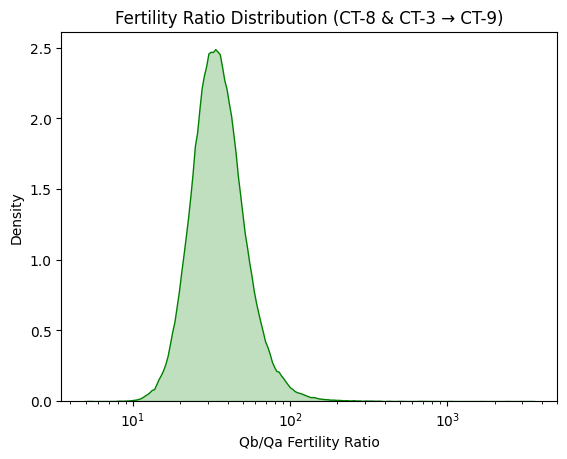

In [11]:
# Flux ordered using CT-8.2 and CT-3 to mix and form CT-9 with calculated fertilities.

np.random.seed(17)

# CT-8.2 and CT-3:
flux_4 = df.loc[3, 'Source_Area'] * CT_4_samples
flux_8 = df.loc[7, 'Source_Area'] * CT_8_samples
i5 = np.where(flux_8 > flux_4)
CT_8_ordered = CT_8_samples[i5]

# CT-3 is independent - no flux ordering needed
CT_3_ordered = CT_3_samples

CT_8_resampled = np.random.choice(CT_8_ordered, size=number_samples, replace=True)
CT_3_resampled = np.random.choice(CT_3_ordered, size=number_samples, replace=True)

print("Modeled Erosion Rates based on monte carlo simulations flux ordered")
print("CT-8 ER: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_8_samples), np.std(CT_8_samples)))
print("CT-3 ER: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_3_samples), np.std(CT_3_samples)))

# Calculating the fertilities for 8, 3 to 9
A_a = df.loc[7, 'Source_Area']          # CT-8 source area
P_a = df.loc[7, 'Surface_Production_Rate']  # CT-8 production rate
E_a = CT_8_samples

# Modified CT-3 source area calculation
A_b_original = df.loc[2, 'Source_Area']     # Original CT-3 source area
A_c = df.loc[8, 'Source_Area']              # CT-9 source area
A_b = (A_c - df.loc[7, 'Source_Area'])  # (CT-9 - CT-8.2)

P_b = df.loc[2, 'Surface_Production_Rate']  # CT-3 production rate
E_b = CT_3_samples
P_c = df.loc[8, 'Surface_Production_Rate']  # CT-9 production rate
E_c = CT_9_samples

Q = (P_c * E_a * A_a - P_a * E_c * A_a) / (P_b * E_c * A_b - P_c * E_b * A_b)
i_f2 = np.where(Q > 0)

plt.figure()
sns.kdeplot(Q[i_f2], bw_adjust=.5, fill=True, color="green", log_scale=True)
plt.xlabel("Qb/Qa Fertility Ratio")
plt.ylabel("Density")
plt.title("Fertility Ratio Distribution (CT-8 & CT-3 → CT-9)")

print("Qb/Qa Fertility Ratio (mean, (25-75% range)): {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.mean(Q[i_f2]), np.percentile(Q[i_f2], 75), np.percentile(Q[i_f2], 25)))
print("Qb/Qa Fertility Ratio (median, (25-75% range)): {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.median(Q[i_f2]), np.percentile(Q[i_f2], 75), np.percentile(Q[i_f2], 25)))

Modeled Erosion Rates based on monte carlo simulations flux ordered
CT-8 ER: 262.9688 ± 22.8529
CT-3 ER: 29.5005 ± 2.4127
Qb/Qa Fertility Ratio (mean, (25-75% range)): 111.2362 (55.5795 - 102.6421)
Qb/Qa Fertility Ratio (median, (25-75% range)): 73.6794 (55.5795 - 102.6421)


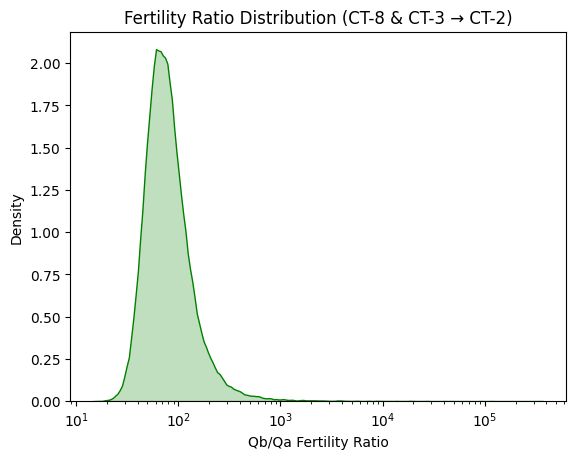

In [12]:
# Flux ordered using CT-8.2 and CT-3 to mix and form CT-2 with calculated fertilities.

np.random.seed(17)

# CT-8.2 and CT-3:
flux_4 = df.loc[3, 'Source_Area'] * CT_4_samples
flux_8 = df.loc[7, 'Source_Area'] * CT_8_samples
i5 = np.where(flux_8 > flux_4)
CT_8_ordered = CT_8_samples[i5]

# CT-3 is independent - no flux ordering needed
CT_3_ordered = CT_3_samples

CT_8_resampled = np.random.choice(CT_8_ordered, size=number_samples, replace=True)
CT_3_resampled = np.random.choice(CT_3_ordered, size=number_samples, replace=True)

print("Modeled Erosion Rates based on monte carlo simulations flux ordered")
print("CT-8 ER: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_8_samples), np.std(CT_8_samples)))
print("CT-3 ER: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_3_samples), np.std(CT_3_samples)))

# Calculating the fertilities for 8, 3 to 2
A_a = df.loc[7, 'Source_Area']          # CT-8 source area
P_a = df.loc[7, 'Surface_Production_Rate']  # CT-8 production rate
E_a = CT_8_samples

# Modified CT-3 source area calculation
A_b_original = df.loc[2, 'Source_Area']     # Original CT-3 source area
A_c = df.loc[1, 'Source_Area']              # CT-2 source area
A_b = A_b_original + (A_c - df.loc[7, 'Source_Area'])  # CT-3 + (CT-2 - CT-8.2)

P_b = df.loc[2, 'Surface_Production_Rate']  # CT-3 production rate
E_b = CT_3_samples
P_c = df.loc[1, 'Surface_Production_Rate']  # CT-2 production rate
E_c = CT_2_samples

Q = (P_c * E_a * A_a - P_a * E_c * A_a) / (P_b * E_c * A_b - P_c * E_b * A_b)
i_f2 = np.where(Q > 0)

plt.figure()
sns.kdeplot(Q[i_f2], bw_adjust=.5, fill=True, color="green", log_scale=True)
plt.xlabel("Qb/Qa Fertility Ratio")
plt.ylabel("Density")
plt.title("Fertility Ratio Distribution (CT-8 & CT-3 → CT-2)")

print("Qb/Qa Fertility Ratio (mean, (25-75% range)): {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.mean(Q[i_f2]), np.percentile(Q[i_f2], 75), np.percentile(Q[i_f2], 25)))
print("Qb/Qa Fertility Ratio (median, (25-75% range)): {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.median(Q[i_f2]), np.percentile(Q[i_f2], 75), np.percentile(Q[i_f2], 25)))

### Subwatershed flux ordered erosion rates

In [13]:
# Flux-ordered erosion rates calculation
# Flow hierarchy: 7→5, 1→6, then 5&6→4, then 4→10→11→8→2→9, 3 independent
np.random.seed(17)

# Flux ordering CT-7 and CT-5:
flux_7 = df.loc[6, 'Source_Area'] * CT_7_samples
flux_5 = df.loc[4, 'Source_Area'] * CT_5_samples
i1 = np.where(flux_5 > flux_7)
print("Success Fraction of Samples (7→5): {0:6.4f}".format(i1[0].size / number_samples))
print("Modeled Erosion Rates based on monte carlo simulations flux ordered")
print("CT-7: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_7_samples[i1]), np.std(CT_7_samples[i1])))
print("CT-5: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_5_samples[i1]), np.std(CT_5_samples[i1])))
print("CT-7, CT-5 correlation: {0:6.4f}".format(np.corrcoef(CT_7_samples[i1], CT_5_samples[i1])[0,1]))
print()

# Flux ordering CT-1 and CT-6:
flux_1 = df.loc[0, 'Source_Area'] * CT_1_samples
flux_6 = df.loc[5, 'Source_Area'] * CT_6_samples
i2 = np.where(flux_6 > flux_1)
print("Success Fraction of Samples (1→6): {0:6.4f}".format(i2[0].size / number_samples))
print("CT-1: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_1_samples[i2]), np.std(CT_1_samples[i2])))
print("CT-6: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_6_samples[i2]), np.std(CT_6_samples[i2])))
print("CT-1, CT-6 correlation: {0:6.4f}".format(np.corrcoef(CT_1_samples[i2], CT_6_samples[i2])[0,1]))
print()

# Flux ordering CT-5&6 and CT-4:
flux_5 = df.loc[4, 'Source_Area'] * CT_5_samples
flux_6 = df.loc[5, 'Source_Area'] * CT_6_samples
flux_56 = flux_5 + flux_6
flux_4 = df.loc[3, 'Source_Area'] * CT_4_samples
i3 = np.where(flux_4 > flux_56)
print("Success Fraction of Samples (5&6→4): {0:6.4f}".format(i3[0].size / number_samples))
print("CT-5: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_5_samples[i3]), np.std(CT_5_samples[i3])))
print("CT-6: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_6_samples[i3]), np.std(CT_6_samples[i3])))
print("CT-4: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_4_samples[i3]), np.std(CT_4_samples[i3])))
print("CT-5&6, CT-4 correlation: {0:6.4f}".format(np.corrcoef((CT_5_samples[i3] + CT_6_samples[i3]), CT_4_samples[i3])[0,1]))
print()

# Flux ordering CT-4 and CT-10:
flux_4 = df.loc[3, 'Source_Area'] * CT_4_samples
flux_10 = df.loc[9, 'Source_Area'] * CT_10_samples
i4 = np.where(flux_10 > flux_4)
print("Success Fraction of Samples (4→10): {0:6.4f}".format(i4[0].size / number_samples))
print("CT-4: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_4_samples[i4]), np.std(CT_4_samples[i4])))
print("CT-10: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_10_samples[i4]), np.std(CT_10_samples[i4])))
print("CT-4, CT-10 correlation: {0:6.4f}".format(np.corrcoef(CT_4_samples[i4], CT_10_samples[i4])[0,1]))
print()

# Flux ordering CT-10 and CT-11:
flux_10 = df.loc[9, 'Source_Area'] * CT_10_samples
flux_11 = df.loc[10, 'Source_Area'] * CT_11_samples
i5 = np.where(flux_11 > flux_10)
print("Success Fraction of Samples (10→11): {0:6.4f}".format(i5[0].size / number_samples))
print("CT-10: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_10_samples[i5]), np.std(CT_10_samples[i5])))
print("CT-11: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_11_samples[i5]), np.std(CT_11_samples[i5])))
print("CT-10, CT-11 correlation: {0:6.4f}".format(np.corrcoef(CT_10_samples[i5], CT_11_samples[i5])[0,1]))
print()

# Flux ordering CT-11 and CT-8:
flux_11 = df.loc[10, 'Source_Area'] * CT_11_samples
flux_8 = df.loc[7, 'Source_Area'] * CT_8_samples
i6 = np.where(flux_8 > flux_11)
print("Success Fraction of Samples (11→8): {0:6.4f}".format(i6[0].size / number_samples))
print("CT-11: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_11_samples[i6]), np.std(CT_11_samples[i6])))
print("CT-8: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_8_samples[i6]), np.std(CT_8_samples[i6])))
print("CT-11, CT-8 correlation: {0:6.4f}".format(np.corrcoef(CT_11_samples[i6], CT_8_samples[i6])[0,1]))
print()

# Flux ordering CT-8 and CT-2:
flux_8 = df.loc[7, 'Source_Area'] * CT_8_samples
flux_2 = df.loc[1, 'Source_Area'] * CT_2_samples
i7 = np.where(flux_2 > flux_8)
print("Success Fraction of Samples (8→2): {0:6.4f}".format(i7[0].size / number_samples))
print("CT-8: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_8_samples[i7]), np.std(CT_8_samples[i7])))
print("CT-2: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_2_samples[i7]), np.std(CT_2_samples[i7])))
print("CT-8, CT-2 correlation: {0:6.4f}".format(np.corrcoef(CT_8_samples[i7], CT_2_samples[i7])[0,1]))
print()

# Flux ordering CT-2 and CT-9:
flux_2 = df.loc[1, 'Source_Area'] * CT_2_samples
flux_9 = df.loc[8, 'Source_Area'] * CT_9_samples
i8 = np.where(flux_9 > flux_2)
print("Success Fraction of Samples (2→9): {0:6.4f}".format(i8[0].size / number_samples))
print("CT-2: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_2_samples[i8]), np.std(CT_2_samples[i8])))
print("CT-9: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_9_samples[i8]), np.std(CT_9_samples[i8])))
print("CT-2, CT-9 correlation: {0:6.4f}".format(np.corrcoef(CT_2_samples[i8], CT_9_samples[i8])[0,1]))
print()

# CT-3 is independent - no flux ordering needed
print("CT-3 is independent - no flux ordering")
print("CT-3: {0:6.4f} ± {1:6.4f}".format(np.mean(CT_3_samples), np.std(CT_3_samples)))
print("CT-3 modified area (CT-9 - CT-8): {0:6.4f}".format(df.loc[8, 'Source_Area'] - df.loc[7, 'Source_Area']))

Success Fraction of Samples (7→5): 0.2100
Modeled Erosion Rates based on monte carlo simulations flux ordered
CT-7: 475.4129 ± 37.1232
CT-5: 413.5117 ± 27.1491
CT-7, CT-5 correlation: 0.6243

Success Fraction of Samples (1→6): 1.0000
CT-1: 22.8970 ± 1.8595
CT-6: 29.8014 ± 2.4379
CT-1, CT-6 correlation: 0.0053

Success Fraction of Samples (5&6→4): 0.0000
CT-5:    nan ±    nan
CT-6:    nan ±    nan
CT-4:    nan ±    nan
CT-5&6, CT-4 correlation:    nan

Success Fraction of Samples (4→10): 1.0000
CT-4: 29.6065 ± 2.4398
CT-10: 245.8567 ± 21.3102
CT-4, CT-10 correlation: 0.0037

Success Fraction of Samples (10→11): 0.9064
CT-10: 243.2910 ± 20.0122
CT-11: 289.4700 ± 22.5773
CT-10, CT-11 correlation: 0.1588

Success Fraction of Samples (11→8): 0.2663
CT-11: 263.9366 ± 18.8844
CT-8: 282.2683 ± 18.3010
CT-11, CT-8 correlation: 0.6011

Success Fraction of Samples (8→2): 0.0000
CT-8:    nan ±    nan
CT-2:    nan ±    nan
CT-8, CT-2 correlation:    nan

Success Fraction of Samples (2→9): 0.9329
CT

/Users/Glong1/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Glong1/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/Glong1/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Glong1/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/Glong1/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/Glong1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWar

### CT-4 fertility based on forced ordering

Success ratio: 0.4768
Fertility Ratio: 730.6484 ± 44075.4563
Fertility Ratio (median, (25-75% range)): 78.5655 (46.7248 - 162.3715)
78.56551670252755


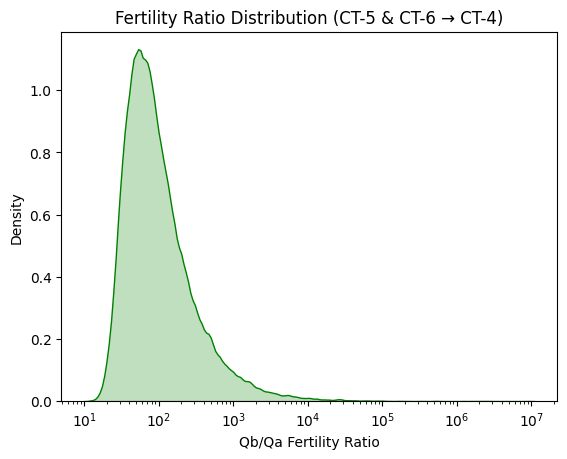

In [14]:
# Quartz fertility calculation for the CT-4, 5, 6 pair:
# basin b will be CT-6
# basin a will be CT-5

# Generate samples using erosion_samples dictionary
CT_6_samples = erosion_samples['CT-6']
CT_5_samples = erosion_samples['CT-5']
CT_4_samples = erosion_samples['CT-4']

# Define parameters using new naming conventions
A_a = df.loc[4, 'Source_Area']          # CT-5 source area
P_a = df.loc[4, 'Surface_Production_Rate']  # CT-5 production rate
E_a = CT_5_samples

A_b = df.loc[5, 'Source_Area']          # CT-6 source area  
P_b = df.loc[5, 'Surface_Production_Rate']  # CT-6 production rate
E_b = CT_6_samples

A_c = df.loc[3, 'Source_Area']          # CT-4 source area
P_c = df.loc[3, 'Surface_Production_Rate']  # CT-4 production rate
E_c = CT_4_samples

# Ensure proper ordering of samples:
i_f1 = np.where(np.logical_or(np.logical_and(CT_4_samples < CT_5_samples, CT_4_samples > CT_6_samples),
                              np.logical_and(CT_4_samples > CT_5_samples, CT_4_samples < CT_6_samples)))
print("Success ratio: {0:6.4f}".format(i_f1[0].size/number_samples))

# Calculate fertility ratios using correctly ordered samples:
Q1 = (P_c * E_a * A_a - P_a * E_c * A_a) / (P_b * E_c * A_b - P_c * E_b * A_b)
i_f2 = np.where(Q1 > 0)

plt.figure()
sns.kdeplot(Q1[i_f2], bw_adjust=.5, fill=True, color="green", log_scale=True)
plt.xlabel("Qb/Qa Fertility Ratio")
plt.ylabel("Density")
plt.title("Fertility Ratio Distribution (CT-5 & CT-6 → CT-4)")

print("Fertility Ratio: {0:6.4f} ± {1:6.4f}".format(np.mean(Q1[i_f2]), np.std(Q1[i_f2])))
print("Fertility Ratio (median, (25-75% range)): {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.median(Q1[i_f2]), np.percentile(Q1[i_f2], 75), np.percentile(Q1[i_f2], 25)))
print(np.median(Q1[i_f2]))

# Calculating zircon fertility ratios

### Definition for calculating 2 to 1 mixing scenarios

def calculate_zircon_fertility_ratios2_to_1(csv_filename, sample_a_key, sample_b_key, 
                                          erosion_samples, df, wct_a, wct_b, 
                                          sample_a_index, sample_b_index,
                                          num_samples=10000, random_seed=17):
    """
    Calculate zircon fertility ratios using Monte Carlo simulation.
    
    Parameters:
    -----------
    csv_filename : str
        Path to CSV file containing mixing coefficients
    sample_a_key : str
        Key for sample A in erosion_samples dictionary
    sample_b_key : str
        Key for sample B in erosion_samples dictionary
    erosion_samples : dict
        Dictionary containing erosion rate samples for each sample
    df : pandas.DataFrame
        DataFrame containing source area data with samples as rows
    wct_a : float
        Weight coefficient for sample A
    wct_b : float
        Weight coefficient for sample B
    sample_a_index : int
        Row index for sample A in the dataframe
    sample_b_index : int
        Row index for sample B in the dataframe
    num_samples : int, optional
        Number of Monte Carlo samples (default: 10000)
    random_seed : int, optional
        Random seed for reproducibility (default: 17)
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'ZA_ZB_samples': array of ZA/ZB ratio samples
        - 'ZB_ZA_samples': array of ZB/ZA ratio samples
        - 'ZA_ZB_median': median ZA/ZB ratio
        - 'ZB_ZA_median': median ZB/ZA ratio
        - 'ZA_ZB_percentiles': (25th, 75th) percentiles for ZA/ZB
        - 'ZB_ZA_percentiles': (25th, 75th) percentiles for ZB/ZA
    """
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Read mixing coefficients from CSV
    wct_a_list, wct_b_list = [], []
    with open(csv_filename, 'r') as file:
        csvfile = csv.reader(file)
        next(csvfile)  # Skip header
        for row in csvfile:
            wct_a_list.append(float(row[0]))
            wct_b_list.append(float(row[1]))
    
    # Calculate ratios and filter zeros
    ratio = np.array(wct_a_list) / np.array(wct_b_list)
    ratio = ratio[ratio != 0]
    
    # Bootstrap sample from ratios
    np.random.seed(random_seed)  # Keep consistent with erosion rate sampling
    ratio_samples = np.random.choice(ratio, replace=True, size=num_samples)
    
    # Get erosion rate samples
    ER_A_samples = erosion_samples[sample_a_key][:num_samples]
    ER_B_samples = erosion_samples[sample_b_key][:num_samples]
    
    # Get source areas from dataframe using provided indices
    WA_A = df.loc[sample_a_index, 'Source_Area']
    WA_B = df.loc[sample_b_index, 'Source_Area']
    
    # Calculate ZA/ZB ratios using the mixing model
    # Formula: ZA/ZB = (ratio/WCT_B) * (ER_B*WA_B) / (ER_A*WA_A)
    ZA_ZB = ratio_samples/wct_b * ER_B_samples*WA_B / (ER_A_samples*WA_A)
    
    # Calculate ZB/ZA (fertility ratio)
    ZB_ZA = 1/ZA_ZB
    
    # Calculate statistics
    results = {
        'ZA_ZB_samples': ZA_ZB,
        'ZB_ZA_samples': ZB_ZA,
        'ZA_ZB_median': np.median(ZA_ZB),
        'ZB_ZA_median': np.median(ZB_ZA),
        'ZA_ZB_percentiles': (np.percentile(ZA_ZB, 25), np.percentile(ZA_ZB, 75)),
        'ZB_ZA_percentiles': (np.percentile(ZB_ZA, 25), np.percentile(ZB_ZA, 75))
    }
    
    return results

def print_fertility_results(results, sample_a_name, sample_b_name):
    """
    Print formatted results from fertility ratio calculation.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from calculate_zircon_fertility_ratios
    sample_a_name : str
        Name of sample A for display
    sample_b_name : str
        Name of sample B for display
    """
    print(f"Z{sample_a_name}/Z{sample_b_name} Ratio Analysis based on Monte Carlo simulations")
    print(f"Median Z{sample_b_name}/Z{sample_a_name}: {results['ZB_ZA_median']:6.4f}")
    print("Z{1}/Z{0} Fertility Ratio (median, (25-75% range)): {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_a_name, sample_b_name,
        results['ZB_ZA_median'], 
        results['ZB_ZA_percentiles'][1], 
        results['ZB_ZA_percentiles'][0]
    ))
    print("Z{0}/Z{1} Fertility Ratio (median, (25-75% range)): {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_a_name, sample_b_name,
        results['ZA_ZB_median'], 
        results['ZA_ZB_percentiles'][1], 
        results['ZA_ZB_percentiles'][0]
    ))

In [55]:
# Definition with filtering of 1s and 0s

def calculate_zircon_fertility_ratios2_to_1(csv_filename, sample_a_key, sample_b_key, 
                                          erosion_samples, df, wct_a, wct_b, 
                                          sample_a_index, sample_b_index,
                                          num_samples=10000, random_seed=17):
    """
    Calculate zircon fertility ratios using Monte Carlo simulation.
    
    Parameters:
    -----------
    csv_filename : str
        Path to CSV file containing mixing coefficients
    sample_a_key : str
        Key for sample A in erosion_samples dictionary
    sample_b_key : str
        Key for sample B in erosion_samples dictionary
    erosion_samples : dict
        Dictionary containing erosion rate samples for each sample
    df : pandas.DataFrame
        DataFrame containing source area data with samples as rows
    wct_a : float
        Weight coefficient for sample A
    wct_b : float
        Weight coefficient for sample B
    sample_a_index : int
        Row index for sample A in the dataframe
    sample_b_index : int
        Row index for sample B in the dataframe
    num_samples : int, optional
        Number of Monte Carlo samples (default: 10000)
    random_seed : int, optional
        Random seed for reproducibility (default: 17)
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'ZA_ZB_samples': array of ZA/ZB ratio samples
        - 'ZB_ZA_samples': array of ZB/ZA ratio samples
        - 'ZA_ZB_median': median ZA/ZB ratio
        - 'ZB_ZA_median': median ZB/ZA ratio
        - 'ZA_ZB_percentiles': (25th, 75th) percentiles for ZA/ZB
        - 'ZB_ZA_percentiles': (25th, 75th) percentiles for ZB/ZA
    """
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Read mixing coefficients from CSV
    wct_a_list, wct_b_list = [], []
    with open(csv_filename, 'r') as file:
        csvfile = csv.reader(file)
        next(csvfile)  # Skip header
        for row in csvfile:
            wct_a_val = float(row[0])
            wct_b_val = float(row[1])
            
            # Only include if neither coefficient is 0 or 1
            if wct_a_val not in [0.0, 1.0] and wct_b_val not in [0.0, 1.0]:
                wct_a_list.append(wct_a_val)
                wct_b_list.append(wct_b_val)
    
    # Calculate ratios (no need to filter zeros again since we already filtered)
    ratio = np.array(wct_a_list) / np.array(wct_b_list)
    
    # Check if we have any valid ratios left
    if len(ratio) == 0:
        raise ValueError("No valid mixing coefficients found after filtering out 0s and 1s")
    
    # Bootstrap sample from ratios
    np.random.seed(random_seed)  # Keep consistent with erosion rate sampling
    ratio_samples = np.random.choice(ratio, replace=True, size=num_samples)
    
    # Get erosion rate samples
    ER_A_samples = erosion_samples[sample_a_key][:num_samples]
    ER_B_samples = erosion_samples[sample_b_key][:num_samples]
    
    # Get source areas from dataframe using provided indices
    WA_A = df.loc[sample_a_index, 'Source_Area']
    WA_B = df.loc[sample_b_index, 'Source_Area']

    # Print values used for calculations
    print(f"Calculation parameters:")
    print(f"Number of valid coefficient pairs after filtering: {len(wct_a_list)}")
    print(f"Source Areas - {sample_a_key}: {WA_A}, {sample_b_key}: {WA_B}")
    print(f"Mean erosion rates - {sample_a_key}: {np.mean(ER_A_samples):.4f}, {sample_b_key}: {np.mean(ER_B_samples):.4f}")
    print(f"Input weight coefficients - {sample_a_key}: {wct_a:.4f}, {sample_b_key}: {wct_b:.4f}")
    print(f"Mean ratio (wct_a/wct_b) from filtered data: {np.mean(ratio_samples):.4f}")
    print(f"Random seed: {random_seed}, Number of samples: {num_samples}")
    print()
    
    # Calculate ZA/ZB ratios using the mixing model
    # Formula: ZA/ZB = (ratio/WCT_B) * (ER_B*WA_B) / (ER_A*WA_A)
    ZA_ZB = ratio_samples/wct_b * ER_B_samples*WA_B / (ER_A_samples*WA_A)
    
    # Calculate ZB/ZA (fertility ratio)
    ZB_ZA = 1/ZA_ZB
    
    # Calculate statistics
    results = {
        'ZA_ZB_samples': ZA_ZB,
        'ZB_ZA_samples': ZB_ZA,
        'ZA_ZB_median': np.median(ZA_ZB),
        'ZB_ZA_median': np.median(ZB_ZA),
        'ZA_ZB_percentiles': (np.percentile(ZA_ZB, 25), np.percentile(ZA_ZB, 75)),
        'ZB_ZA_percentiles': (np.percentile(ZB_ZA, 25), np.percentile(ZB_ZA, 75))
    }
    
    return results

def print_fertility_results(results, sample_a_name, sample_b_name):
    """
    Print formatted results from fertility ratio calculation.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from calculate_zircon_fertility_ratios
    sample_a_name : str
        Name of sample A for display
    sample_b_name : str
        Name of sample B for display
    """
    print(f"Z{sample_a_name}/Z{sample_b_name} Ratio Analysis based on Monte Carlo simulations")
    print(f"Median Z{sample_b_name}/Z{sample_a_name}: {results['ZB_ZA_median']:6.4f}")
    print("Z{1}/Z{0} Fertility Ratio (median, (25-75% range)): {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_a_name, sample_b_name,
        results['ZB_ZA_median'], 
        results['ZB_ZA_percentiles'][1], 
        results['ZB_ZA_percentiles'][0]
    ))
    print("Z{0}/Z{1} Fertility Ratio (median, (25-75% range)): {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_a_name, sample_b_name,
        results['ZA_ZB_median'], 
        results['ZA_ZB_percentiles'][1], 
        results['ZA_ZB_percentiles'][0]
    ))

### Definition for plotting violin plots for mixing coeffs 

In [16]:
# Definition for plotting violin plots for mixing coeffs filtering for 0:1 ratios

def plot_mixing_violin_filtered(csv_file, best_fit_values=None, labels=None, colors=None, 
                               title="Parent mixtures (violin plot)", figsize=(6, 3), 
                               violin_width=0.3, save_path=None, filter_zeros_ones=True):
    """
    Create a horizontal violin plot for mixing coefficients with optional filtering.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing mixing coefficients
    best_fit_values : list, optional
        Best fit values to overlay on the plot
    labels : list, optional
        Labels for each component
    colors : list, optional
        Colors for each violin
    title : str
        Plot title
    figsize : tuple
        Figure size (width, height)
    violin_width : float
        Width of violin plots
    save_path : str, optional
        Path to save the figure
    filter_zeros_ones : bool
        Whether to filter out rows containing 0s or 1s (default: True)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    filtered_data : numpy array
        The filtered data used for plotting (for verification)
    """
    
    # Read mixing coefficients from CSV
    mixing_data = []
    with open(csv_file, 'r') as file:
        csvfile = csv.reader(file)
        next(csvfile)  # Skip header
        for row in csvfile:
            row_values = [float(val) for val in row]
            
            # Apply same filtering as in calculate_zircon_fertility_ratios2_to_1
            if filter_zeros_ones:
                # Only include if no coefficient is 0 or 1
                if not any(val in [0.0, 1.0] for val in row_values):
                    mixing_data.append(row_values)
            else:
                mixing_data.append(row_values)
    
    # Convert to numpy array
    mixing_data = np.array(mixing_data)
    
    # Check if we have data after filtering
    if len(mixing_data) == 0:
        raise ValueError("No valid mixing coefficients found after filtering")
    
    n_components = mixing_data.shape[1]
    
    # Print info about filtering
    if filter_zeros_ones:
        print(f"Filtered data: {len(mixing_data)} rows remaining after removing 0s and 1s")
    else:
        print(f"Unfiltered data: {len(mixing_data)} rows")
    
    # Separate each column into a list for violinplot
    data_for_violin = [mixing_data[:, i] for i in range(n_components)]
    
    # Set default labels if not provided
    if labels is None:
        labels = [f'Component {i+1}' for i in range(n_components)]
    
    # Set default colors if not provided
    if colors is None:
        default_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
        colors = default_colors[:n_components]
    
    # Create violin plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create violin plots
    positions = list(range(1, n_components + 1))
    parts = ax.violinplot(data_for_violin, positions=positions, vert=False, 
                         widths=violin_width, showmeans=False, 
                         showextrema=False, showmedians=True)
    
    # Format violin plot bodies with colors and styling
    for i, pc in enumerate(parts['bodies']):
        pc.set_color(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    # Format median lines
    vp = parts['cmedians']
    vp.set_edgecolor('black')
    
    # Add best fit values if provided
    if best_fit_values is not None:
        for i, value in enumerate(best_fit_values):
            ax.scatter(value, i+1, color='white', s=50, edgecolor='black', 
                      linewidth=2, zorder=10, marker='.')
    
    # Set axis properties
    ax.set_xlim(0, 1)
    ax.set_ylim(0.5, n_components + 0.5)
    ax.set_yticks(positions)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Mixing proportion')
    ax.set_title(title)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax, mixing_data

In [17]:
"""# Original calculation, keeping for reference, remove when everything is vetted. 

# CT-5 + CT-6 to CT-4

import csv

# Set random seed for reproducibility
np.random.seed(17)

# Read mixing coefficients from CSV
filename = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-4.csv'
wct_5, wct_6 = [], []
with open(filename, 'r') as file:
    csvfile = csv.reader(file)
    next(csvfile)  # Skip header
    for row in csvfile:
        wct_5.append(float(row[0]))
        wct_6.append(float(row[1]))

# Calculate ratios and filter zeros
ratio = np.array(wct_5) / np.array(wct_6)
ratio = ratio[ratio != 0]

# Constants
WCT_5 = 0.257
WCT_6 = 0.743
num = 10000

# Bootstrap sample from ratios
np.random.seed(17)  # Keep consistent with erosion rate sampling
ratio_samples = np.random.choice(ratio, replace=True, size=num)

# Get erosion rate samples for CT-5 and CT-6 from the erosion_samples dictionary
# (assuming erosion_samples was created as in your example code)
ER_CT5_samples = erosion_samples['CT-5'][:num]  # Take first 10000 samples
ER_CT6_samples = erosion_samples['CT-6'][:num]  # Take first 10000 samples

# Calculate ZA/ZB ratios using the mixing model
# Formula: ZA/ZB = (ratio/WCT_6) * (ER_CT6*WA[5]) / (ER_CT5*WA[4])
# Assuming WA values are available from df (source areas or widths)
WA_CT5 = df.loc[4, 'Source_Area']  # or appropriate width column for CT-5
WA_CT6 = df.loc[5, 'Source_Area']  # or appropriate width column for CT-6

ZA_ZB = ratio_samples/WCT_6 * ER_CT6_samples*WA_CT6 / (ER_CT5_samples*WA_CT5)

# Calculate ZB/ZA (fertility ratio)
ZB_ZA = 1/ZA_ZB

# Print results
print("ZA/ZB Ratio Analysis based on Monte Carlo simulations")
print(f"Median ZB/ZA: {np.median(ZB_ZA):6.4f}")
print("ZB/ZA Fertility Ratio (median, (25-75% range)): {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.median(ZB_ZA), 
    np.percentile(ZB_ZA, 75), 
    np.percentile(ZB_ZA, 25)
))
print("ZA/ZB Fertility Ratio (median, (25-75% range)): {0:6.4f} ({2:6.4f} - {1:6.4f})".format(
    np.median(ZA_ZB), 
    np.percentile(ZA_ZB, 75), 
    np.percentile(ZA_ZB, 25)
))"""

'# Original calculation, keeping for reference, remove when everything is vetted. \n\n# CT-5 + CT-6 to CT-4\n\nimport csv\n\n# Set random seed for reproducibility\nnp.random.seed(17)\n\n# Read mixing coefficients from CSV\nfilename = \'/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-4.csv\'\nwct_5, wct_6 = [], []\nwith open(filename, \'r\') as file:\n    csvfile = csv.reader(file)\n    next(csvfile)  # Skip header\n    for row in csvfile:\n        wct_5.append(float(row[0]))\n        wct_6.append(float(row[1]))\n\n# Calculate ratios and filter zeros\nratio = np.array(wct_5) / np.array(wct_6)\nratio = ratio[ratio != 0]\n\n# Constants\nWCT_5 = 0.257\nWCT_6 = 0.743\nnum = 10000\n\n# Bootstrap sample from ratios\nnp.random.seed(17)  # Keep consistent with erosion rate sampling\nratio_samples = np.random.choice(ratio, replace=True, size=num)\n\n# Get erosion rate samples for CT-5 and CT-6 from the erosion_samples dictionary\n# (assuming erosi

### CT-5 + CT-6 to CT-4 analysis

In [56]:
# Call for CT-5 + CT-6 to CT-4 analysis
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-4.csv'
results = calculate_zircon_fertility_ratios2_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-5',
    sample_b_key='CT-6', 
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.27161630883411,  # WCT_5
    wct_b=0.72838369116589,  # WCT_6
    sample_a_index=4,  # Row index for CT-5 in dataframe
    sample_b_index=5,  # Row index for CT-6 in dataframe
    num_samples=10000,
    random_seed=17
)

print_fertility_results(results, 'CT-5', 'CT-6')

Calculation parameters:
Number of valid coefficient pairs after filtering: 4952
Source Areas - CT-5: 1495.897, CT-6: 2573.245
Mean erosion rates - CT-5: 386.6060, CT-6: 29.8388
Input weight coefficients - CT-5: 0.2716, CT-6: 0.7284
Mean ratio (wct_a/wct_b) from filtered data: 0.3823
Random seed: 17, Number of samples: 10000

ZCT-5/ZCT-6 Ratio Analysis based on Monte Carlo simulations
Median ZCT-6/ZCT-5: 15.2498
ZCT-6/ZCT-5 Fertility Ratio (median, (25-75% range)): 15.2498 (11.3736 - 21.1085)
ZCT-5/ZCT-6 Fertility Ratio (median, (25-75% range)): 0.0656 (0.0474 - 0.0879)


Filtered data: 4952 rows remaining after removing 0s and 1s


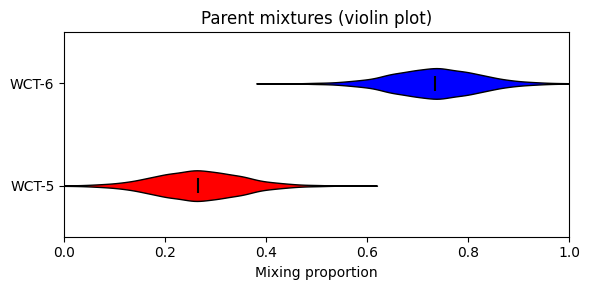

In [19]:
# Violin plots for CT-5 CT-6 to CT-4 excluding 0, 1 values
fig, ax, filtered_data = plot_mixing_violin_filtered('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-4.csv',
    #best_fit_values=[0.27161630883411, 0.72838369116589],
    labels=['WCT-5', 'WCT-6'],
    colors=['red', 'blue'],
    title="Parent mixtures (violin plot)",
    save_path='Figures/violin_ct-5_ct-6_to_ct-4_filtered.png')

### CT-5 + CT-6 to CT-10 analysis

In [20]:
# Call for CT-5 + CT-6 to CT-10 analysis
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-10.csv'
results = calculate_zircon_fertility_ratios2_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-5',
    sample_b_key='CT-6', 
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.663687307145245,  # WCT_5
    wct_b=0.336312692854755,  # WCT_6
    sample_a_index=4,  # Row index for CT-5 in dataframe
    sample_b_index=5,  # Row index for CT-6 in dataframe
    num_samples=10000,
    random_seed=17
)

print_fertility_results(results, 'CT-5', 'CT-6')

ZCT-5/ZCT-6 Ratio Analysis based on Monte Carlo simulations
Median ZCT-6/ZCT-5: 1.4027
ZCT-6/ZCT-5 Fertility Ratio (median, (25-75% range)): 1.4027 (0.9697 - 2.2104)
ZCT-5/ZCT-6 Fertility Ratio (median, (25-75% range)): 0.7129 (0.4524 - 1.0313)


Filtered data: 5000 rows remaining after removing 0s and 1s


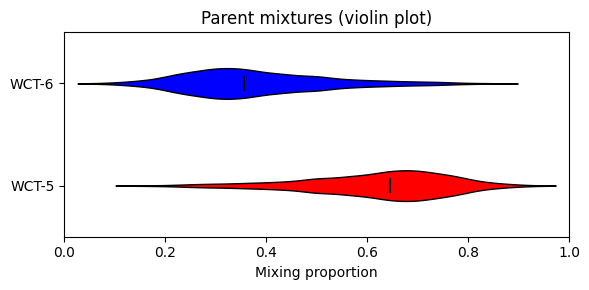

In [21]:
# Violin plots for CT-5 CT-5 to CT-10 excluding 0, 1 values
fig, ax, filtered_data = plot_mixing_violin_filtered('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-10.csv',
    #best_fit_values=[0.663687307145245, 0.336312692854755],
    labels=['WCT-5', 'WCT-6'],
    colors=['red', 'blue'],
    title="Parent mixtures (violin plot)",
    save_path='Figures/violin_ct-5_ct-6_to_ct-10_filtered.png')

### CT-5 + CT-6 to CT-11 analysis

In [22]:
# Call for CT-5 + CT-6 to CT-11 analysis
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-11.csv'
results = calculate_zircon_fertility_ratios2_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-5',
    sample_b_key='CT-6', 
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.49460485898264,  # WCT_5
    wct_b=0.50539514101736,  # WCT_6
    sample_a_index=4,  # Row index for CT-5 in dataframe
    sample_b_index=5,  # Row index for CT-6 in dataframe
    num_samples=10000,
    random_seed=17
)

print_fertility_results(results, 'CT-5', 'CT-6')

ZCT-5/ZCT-6 Ratio Analysis based on Monte Carlo simulations
Median ZCT-6/ZCT-5: 4.5318
ZCT-6/ZCT-5 Fertility Ratio (median, (25-75% range)): 4.5318 (2.9249 - 7.7626)
ZCT-5/ZCT-6 Fertility Ratio (median, (25-75% range)): 0.2207 (0.1288 - 0.3419)


Filtered data: 4999 rows remaining after removing 0s and 1s


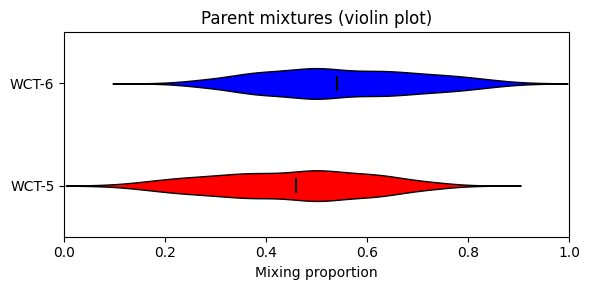

In [23]:
# Violin plots for CT-5 CT-5 to CT-11 excluding 0, 1 values
fig, ax, filtered_data = plot_mixing_violin_filtered('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-11.csv',
    #best_fit_values=[0.49460485898264, 0.50539514101736],
    labels=['WCT-5', 'WCT-6'],
    colors=['red', 'blue'],
    title="Parent mixtures (violin plot)",
    save_path='Figures/violin_ct-5_ct-6_to_ct-11_filtered.png')                    

### CT-5 + CT-6 to CT-8.2 analysis

In [24]:
# Call for CT-5 + CT-6 to CT-8.2 analysis
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-8.2.csv'
results = calculate_zircon_fertility_ratios2_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-5',
    sample_b_key='CT-6', 
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.559243657338644,  # WCT_5
    wct_b=0.440756342661356,  # WCT_6
    sample_a_index=4,  # Row index for CT-5 in dataframe
    sample_b_index=5,  # Row index for CT-6 in dataframe
    num_samples=10000,
    random_seed=17
)

print_fertility_results(results, 'CT-5', 'CT-6')

ZCT-5/ZCT-6 Ratio Analysis based on Monte Carlo simulations
Median ZCT-6/ZCT-5: 2.9202
ZCT-6/ZCT-5 Fertility Ratio (median, (25-75% range)): 2.9202 (2.1066 - 4.2514)
ZCT-5/ZCT-6 Fertility Ratio (median, (25-75% range)): 0.3424 (0.2352 - 0.4747)


Filtered data: 5000 rows remaining after removing 0s and 1s


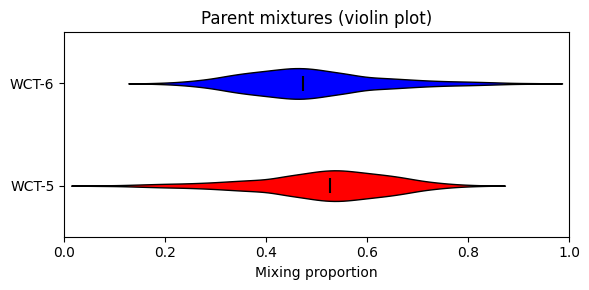

In [25]:
# Violin plots for CT-5 + CT-6 to CT-8.2 excluding 0, 1 values
fig, ax, filtered_data = plot_mixing_violin_filtered('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_to_ct-8.2.csv',
    #best_fit_values=[0.559243657338644, 0.440756342661356],
    labels=['WCT-5', 'WCT-6'],
    colors=['red', 'blue'],
    title="Parent mixtures (violin plot)",
    save_path='Figures/violin_ct-5_ct-6_to_ct-8.2_filtered.png')

### CT-4 + CT-3 to CT-9 analysis

In [29]:
# Call for CT-4 + CT-3 to CT-9 analysis
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-4_ct-3_to_ct-9.csv'
results = calculate_zircon_fertility_ratios2_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-4',
    sample_b_key='CT-3', 
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.937480464786899,  # WCT_4
    wct_b=0.0625195352131011,  # WCT_3
    sample_a_index=3,  # Row index for CT-4 in dataframe
    sample_b_index=2,  # Row index for CT-3 in dataframe
    num_samples=10000,
    random_seed=17
)

print_fertility_results(results, 'CT-4', 'CT-3')

ZCT-4/ZCT-3 Ratio Analysis based on Monte Carlo simulations
Median ZCT-3/ZCT-4: 0.1050
ZCT-3/ZCT-4 Fertility Ratio (median, (25-75% range)): 0.1050 (0.0800 - 0.1361)
ZCT-4/ZCT-3 Fertility Ratio (median, (25-75% range)): 9.5269 (7.3455 - 12.5062)


Filtered data: 4556 rows remaining after removing 0s and 1s


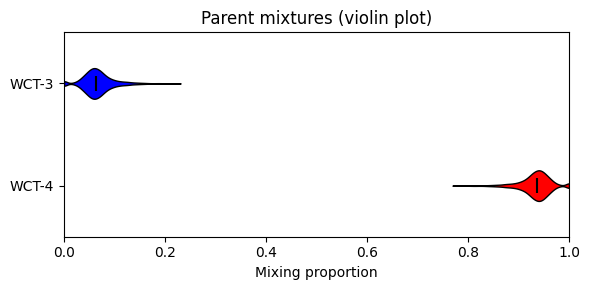

In [30]:
# Violin plots for CT-4 + CT-3 to CT-9 excluding 0, 1 values
fig, ax, filtered_data = plot_mixing_violin_filtered('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-4_ct-3_to_ct-9.csv',
    #best_fit_values=[0.937480464786899, 0.0625195352131011],
    labels=['WCT-4', 'WCT-3'],
    colors=['red', 'blue'],
    title="Parent mixtures (violin plot)",
    save_path='Figures/violin_ct-4_ct-3_to_ct-9_filtered.png')

### CT-10 + CT-3 to CT-9 analysis

In [42]:
# Call for CT-10 + CT-3 to CT-9 analysis
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-10_ct-3_to_ct-9.csv'
results = calculate_zircon_fertility_ratios2_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-10',
    sample_b_key='CT-3', 
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.881432805539908,  # WCT_10
    wct_b=0.118567194460092,  # WCT_3
    sample_a_index=9,  # Row index for CT-10 in dataframe
    sample_b_index=2,  # Row index for CT-3 in dataframe
    num_samples=10000,
    random_seed=17
)

print_fertility_results(results, 'CT-10', 'CT-3')

ZCT-10/ZCT-3 Ratio Analysis based on Monte Carlo simulations
Median ZCT-3/ZCT-10: 3.8142
ZCT-3/ZCT-10 Fertility Ratio (median, (25-75% range)): 3.8142 (2.5569 - 5.5424)
ZCT-10/ZCT-3 Fertility Ratio (median, (25-75% range)): 0.2622 (0.1804 - 0.3911)


Filtered data: 5000 rows remaining after removing 0s and 1s


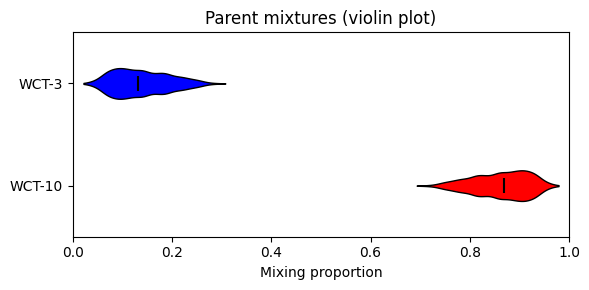

In [43]:
# Violin plots for CT-10 + CT-3 to CT-9 excluding 0, 1 values
fig, ax, filtered_data = plot_mixing_violin_filtered('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-10_ct-3_to_ct-9.csv',
    #best_fit_values=[0.881432805539908, 0.118567194460092],
    labels=['WCT-10', 'WCT-3'],
    colors=['red', 'blue'],
    title="Parent mixtures (violin plot)",
    save_path='Figures/violin_ct-10_ct-3_to_ct-9_filtered.png')

### CT-11 + CT-3 to CT-9 analysis

In [45]:
# Call for CT-11 + CT-3 to CT-9 analysis
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-11_ct-3_to_ct-9.csv'
results = calculate_zircon_fertility_ratios2_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-11',
    sample_b_key='CT-3', 
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.860000109917762,  # WCT_11
    wct_b=0.139999890082238,  # WCT_3
    sample_a_index=10,  # Row index for CT-11 in dataframe
    sample_b_index=2,  # Row index for CT-3 in dataframe
    num_samples=10000,
    random_seed=17
)

print_fertility_results(results, 'CT-11', 'CT-3')

ZCT-11/ZCT-3 Ratio Analysis based on Monte Carlo simulations
Median ZCT-3/ZCT-11: 4.4293
ZCT-3/ZCT-11 Fertility Ratio (median, (25-75% range)): 4.4293 (2.9758 - 6.6679)
ZCT-11/ZCT-3 Fertility Ratio (median, (25-75% range)): 0.2258 (0.1500 - 0.3360)


Filtered data: 4999 rows remaining after removing 0s and 1s


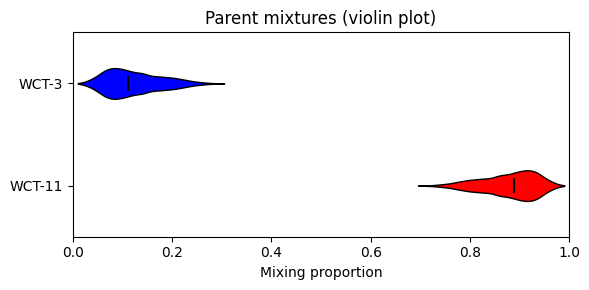

In [46]:
# Violin plots for CT-11 + CT-3 to CT-9 excluding 0, 1 values
fig, ax, filtered_data = plot_mixing_violin_filtered('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-11_ct-3_to_ct-9.csv',
    #best_fit_values=[0.860000109917762, 0.139999890082238],
    labels=['WCT-11', 'WCT-3'],
    colors=['red', 'blue'],
    title="Parent mixtures (violin plot)",
    save_path='Figures/violin_ct-11_ct-3_to_ct-9_filtered.png')

### CT-8.2 + CT-3 to CT-9 analysis

In [49]:
# Call for CT-8.2 + CT-3 to CT-9 analysis
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-8.2_ct-3_to_ct-9.csv'
results = calculate_zircon_fertility_ratios2_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-8',
    sample_b_key='CT-3', 
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.830589798839197,  # WCT_8.2
    wct_b=0.169410201160803,  # WCT_3
    sample_a_index=7,  # Row index for CT-8.2 in dataframe
    sample_b_index=2,  # Row index for CT-3 in dataframe
    num_samples=10000,
    random_seed=17
)

print_fertility_results(results, 'CT-8', 'CT-3')

ZCT-8/ZCT-3 Ratio Analysis based on Monte Carlo simulations
Median ZCT-3/ZCT-8: 5.9360
ZCT-3/ZCT-8 Fertility Ratio (median, (25-75% range)): 5.9360 (3.8827 - 8.5129)
ZCT-8/ZCT-3 Fertility Ratio (median, (25-75% range)): 0.1685 (0.1175 - 0.2576)


Filtered data: 4996 rows remaining after removing 0s and 1s


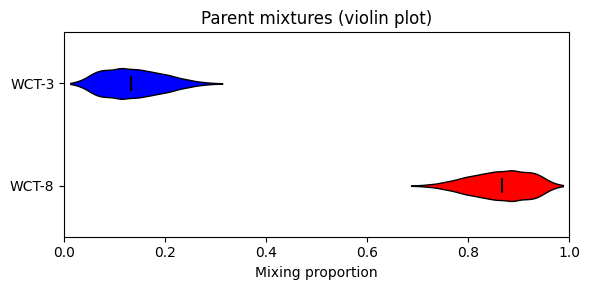

In [51]:
# Violin plots for CT-8.2 + CT-3 to CT-9 excluding 0, 1 values
fig, ax, filtered_data = plot_mixing_violin_filtered('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-8.2_ct-3_to_ct-9.csv',
    #best_fit_values=[0.830589798839197, 0.169410201160803],
    labels=['WCT-8', 'WCT-3'],
    colors=['red', 'blue'],
    title="Parent mixtures (violin plot)",
    save_path='Figures/violin_ct-8.2ct-3_to_ct-9_filtered.png')

# Calculating Zircon Feritlity Ratios 3 to 1

In [53]:
import numpy as np
import csv

def calculate_zircon_fertility_ratios3_to_1(csv_filename, sample_a_key, sample_b_key, sample_c_key,
                                          erosion_samples, df, wct_a, wct_b, wct_c,
                                          sample_a_index, sample_b_index, sample_c_index,
                                          num_samples=10000, random_seed=17):
    """
    Calculate zircon fertility ratios for three samples using Monte Carlo simulation.
    
    Parameters:
    -----------
    csv_filename : str
        Path to CSV file containing mixing coefficients (3 columns: wct_a, wct_b, wct_c)
    sample_a_key : str
        Key for sample A in erosion_samples dictionary
    sample_b_key : str
        Key for sample B in erosion_samples dictionary
    sample_c_key : str
        Key for sample C in erosion_samples dictionary
    erosion_samples : dict
        Dictionary containing erosion rate samples for each sample
    df : pandas.DataFrame
        DataFrame containing source area data with samples as rows
    wct_a : float
        Weight coefficient for sample A (not used in current implementation)
    wct_b : float
        Weight coefficient for sample B (not used in current implementation)
    wct_c : float
        Weight coefficient for sample C (not used in current implementation)
    sample_a_index : int
        Row index for sample A in the dataframe
    sample_b_index : int
        Row index for sample B in the dataframe
    sample_c_index : int
        Row index for sample C in the dataframe
    num_samples : int, optional
        Number of Monte Carlo samples (default: 10000)
    random_seed : int, optional
        Random seed for reproducibility (default: 17)
    
    Returns:
    --------
    dict
        Dictionary containing all ratio samples, medians, and percentiles for all 6 combinations
    """
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Read mixing coefficients from CSV
    wct_a_list, wct_b_list, wct_c_list = [], [], []
    with open(csv_filename, 'r') as file:
        csvfile = csv.reader(file)
        next(csvfile)  # Skip header
        for row in csvfile:
            wct_a_val = float(row[0])
            wct_b_val = float(row[1])
            wct_c_val = float(row[2])
            
            # Only include if none of the coefficients is 0 or 1
            if (wct_a_val not in [0.0, 1.0] and 
                wct_b_val not in [0.0, 1.0] and 
                wct_c_val not in [0.0, 1.0]):
                wct_a_list.append(wct_a_val)
                wct_b_list.append(wct_b_val)
                wct_c_list.append(wct_c_val)
    
    # Check if we have any valid coefficients left
    if len(wct_a_list) == 0:
        raise ValueError("No valid mixing coefficients found after filtering out 0s and 1s")
    
    # Bootstrap sample from coefficients
    np.random.seed(random_seed)
    wct_a_sampled = np.random.choice(wct_a_list, size=num_samples, replace=True)
    wct_b_sampled = np.random.choice(wct_b_list, size=num_samples, replace=True)
    wct_c_sampled = np.random.choice(wct_c_list, size=num_samples, replace=True)
    
    # Get erosion rate samples
    ER_A_samples = erosion_samples[sample_a_key][:num_samples]
    ER_B_samples = erosion_samples[sample_b_key][:num_samples]
    ER_C_samples = erosion_samples[sample_c_key][:num_samples]
    
    # Get source areas from dataframe using provided indices
    WA_A = df.loc[sample_a_index, 'Source_Area']
    WA_B = df.loc[sample_b_index, 'Source_Area']
    WA_C = df.loc[sample_c_index, 'Source_Area']
    
    # Print values used for calculations
    print(f"Calculation parameters:")
    print(f"Number of valid coefficient sets after filtering: {len(wct_a_list)}")
    print(f"Source Areas - {sample_a_key}: {WA_A}, {sample_b_key}: {WA_B}, {sample_c_key}: {WA_C}")
    print(f"Mean erosion rates - {sample_a_key}: {np.mean(ER_A_samples):.4f}, {sample_b_key}: {np.mean(ER_B_samples):.4f}, {sample_c_key}: {np.mean(ER_C_samples):.4f}")
    print(f"Mean mixing coefficients - {sample_a_key}: {np.mean(wct_a_sampled):.4f}, {sample_b_key}: {np.mean(wct_b_sampled):.4f}, {sample_c_key}: {np.mean(wct_c_sampled):.4f}")
    print(f"Random seed: {random_seed}, Number of samples: {num_samples}")
    print()
    
    # Calculate the total flux denominator for normalization
    # This represents the total sediment flux from all three sources
    total_flux = ER_A_samples * WA_A + ER_B_samples * WA_B + ER_C_samples * WA_C
    
    # Calculate ZA/ZD, ZB/ZD, ZC/ZD ratios (where D represents the total)
    ZA_ZD = wct_a_sampled * total_flux / (ER_A_samples * WA_A)
    ZB_ZD = wct_b_sampled * total_flux / (ER_B_samples * WA_B)
    ZC_ZD = wct_c_sampled * total_flux / (ER_C_samples * WA_C)
    
    # Calculate all pairwise ratios
    ZA_ZB = ZA_ZD / ZB_ZD
    ZB_ZA = ZB_ZD / ZA_ZD
    ZA_ZC = ZA_ZD / ZC_ZD
    ZC_ZA = ZC_ZD / ZA_ZD
    ZB_ZC = ZB_ZD / ZC_ZD
    ZC_ZB = ZC_ZD / ZB_ZD
    
    # Calculate statistics for all ratios
    results = {
        # Individual ratios relative to total
        'ZA_ZD_samples': ZA_ZD,
        'ZB_ZD_samples': ZB_ZD,
        'ZC_ZD_samples': ZC_ZD,
        'ZA_ZD_median': np.median(ZA_ZD),
        'ZB_ZD_median': np.median(ZB_ZD),
        'ZC_ZD_median': np.median(ZC_ZD),
        
        # Pairwise ratios
        'ZA_ZB_samples': ZA_ZB,
        'ZB_ZA_samples': ZB_ZA,
        'ZA_ZC_samples': ZA_ZC,
        'ZC_ZA_samples': ZC_ZA,
        'ZB_ZC_samples': ZB_ZC,
        'ZC_ZB_samples': ZC_ZB,
        
        # Medians
        'ZA_ZB_median': np.median(ZA_ZB),
        'ZB_ZA_median': np.median(ZB_ZA),
        'ZA_ZC_median': np.median(ZA_ZC),
        'ZC_ZA_median': np.median(ZC_ZA),
        'ZB_ZC_median': np.median(ZB_ZC),
        'ZC_ZB_median': np.median(ZC_ZB),
        
        # Percentiles (25th, 75th)
        'ZA_ZB_percentiles': (np.percentile(ZA_ZB, 25), np.percentile(ZA_ZB, 75)),
        'ZB_ZA_percentiles': (np.percentile(ZB_ZA, 25), np.percentile(ZB_ZA, 75)),
        'ZA_ZC_percentiles': (np.percentile(ZA_ZC, 25), np.percentile(ZA_ZC, 75)),
        'ZC_ZA_percentiles': (np.percentile(ZC_ZA, 25), np.percentile(ZC_ZA, 75)),
        'ZB_ZC_percentiles': (np.percentile(ZB_ZC, 25), np.percentile(ZB_ZC, 75)),
        'ZC_ZB_percentiles': (np.percentile(ZC_ZB, 25), np.percentile(ZC_ZB, 75))
    }
    
    return results

def print_fertility_results_3sample(results, sample_a_name, sample_b_name, sample_c_name):
    """
    Print formatted results from 3-sample fertility ratio calculation.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from calculate_zircon_fertility_ratios3_to_1
    sample_a_name : str
        Name of sample A for display
    sample_b_name : str
        Name of sample B for display
    sample_c_name : str
        Name of sample C for display
    """
    print(f"Z{sample_a_name}/Z{sample_b_name}/Z{sample_c_name} Ratio Analysis based on Monte Carlo simulations")
    print()
    
    # Print individual ratios relative to total
    print("Individual Ratios (relative to total):")
    print(f"Median Z{sample_a_name}/ZD: {results['ZA_ZD_median']:6.4f}")
    print(f"Median Z{sample_b_name}/ZD: {results['ZB_ZD_median']:6.4f}")
    print(f"Median Z{sample_c_name}/ZD: {results['ZC_ZD_median']:6.4f}")
    print()
    
    # Print pairwise medians
    print("Pairwise Ratio Medians:")
    print(f"({sample_a_name}_{sample_b_name}) {results['ZA_ZB_median']:6.4f}")
    print(f"({sample_a_name}_{sample_c_name}) {results['ZA_ZC_median']:6.4f}")
    print(f"({sample_b_name}_{sample_a_name}) {results['ZB_ZA_median']:6.4f}")
    print(f"({sample_c_name}_{sample_a_name}) {results['ZC_ZA_median']:6.4f}")
    print(f"({sample_c_name}_{sample_b_name}) {results['ZC_ZB_median']:6.4f}")
    print()
    
    # Print detailed fertility ratios with percentiles
    print("Fertility Ratios (median, (25-75% range)):")
    print("Z{1}_Z{0} Fertility Ratio: {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_a_name, sample_b_name,
        results['ZB_ZA_median'], 
        results['ZB_ZA_percentiles'][1], 
        results['ZB_ZA_percentiles'][0]
    ))
    print("Z{0}_Z{1} Fertility Ratio: {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_a_name, sample_b_name,
        results['ZA_ZB_median'], 
        results['ZA_ZB_percentiles'][1], 
        results['ZA_ZB_percentiles'][0]
    ))
    print("Z{0}_Z{1} Fertility Ratio: {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_a_name, sample_c_name,
        results['ZA_ZC_median'], 
        results['ZA_ZC_percentiles'][1], 
        results['ZA_ZC_percentiles'][0]
    ))
    print("Z{1}_Z{0} Fertility Ratio: {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_a_name, sample_c_name,
        results['ZC_ZA_median'], 
        results['ZC_ZA_percentiles'][1], 
        results['ZC_ZA_percentiles'][0]
    ))
    print("Z{0}_Z{1} Fertility Ratio: {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_b_name, sample_c_name,
        results['ZB_ZC_median'], 
        results['ZB_ZC_percentiles'][1], 
        results['ZB_ZC_percentiles'][0]
    ))
    print("Z{1}_Z{0} Fertility Ratio: {2:6.4f} ({4:6.4f} - {3:6.4f})".format(
        sample_b_name, sample_c_name,
        results['ZC_ZB_median'], 
        results['ZC_ZB_percentiles'][1], 
        results['ZC_ZB_percentiles'][0]
    ))



### CT-5 + CT-6 + CT-3 to CT-9 analysis

In [61]:
# Call for CT-5 + CT-6 + CT-3 to CT-9  
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_ct-3_to_ct-9.csv'
results = calculate_zircon_fertility_ratios3_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-5',
    sample_b_key='CT-6', 
    sample_c_key='CT-3',
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.488579493794613,  # WCT_5 
    wct_b=0.368302354785004,  # WCT_6
    wct_c=0.143118151420383,  # WCT_3
    sample_a_index=4,  # Row index for CT-5 in dataframe
    sample_b_index=5,  # Row index for CT-6 in dataframe  
    sample_c_index=2,  # Row index for Canyon in dataframe (you'll need to set this)
    num_samples=10000,
    random_seed=17
)

print_fertility_results_3sample(results, 'CT-5', 'CT-6', 'CT-3')

Calculation parameters:
Number of valid coefficient sets after filtering: 4866
Source Areas - CT-5: 1495.897, CT-6: 2573.245, CT-3: 189.205
Mean erosion rates - CT-5: 386.6060, CT-6: 29.8388, CT-3: 29.4593
Mean mixing coefficients - CT-5: 0.6186, CT-6: 0.2540, CT-3: 0.1275
Random seed: 17, Number of samples: 10000

ZCT-5/ZCT-6/ZCT-3 Ratio Analysis based on Monte Carlo simulations

Individual Ratios (relative to total):
Median ZCT-5/ZD: 0.7178
Median ZCT-6/ZD: 2.2315
Median ZCT-3/ZD: 14.5352

Pairwise Ratio Medians:
(CT-5_CT-6) 0.3213
(CT-5_CT-3) 0.0484
(CT-6_CT-5) 3.1122
(CT-3_CT-5) 20.6684
(CT-3_CT-6) 6.8995

Fertility Ratios (median, (25-75% range)):
ZCT-6_ZCT-5 Fertility Ratio: 3.1122 (1.0844 - 4.9982)
ZCT-5_ZCT-6 Fertility Ratio: 0.3213 (0.2001 - 0.9222)
ZCT-5_ZCT-3 Fertility Ratio: 0.0484 (0.0336 - 0.0698)
ZCT-3_ZCT-5 Fertility Ratio: 20.6684 (14.3181 - 29.7826)
ZCT-6_ZCT-3 Fertility Ratio: 0.1449 (0.0516 - 0.2480)
ZCT-3_ZCT-6 Fertility Ratio: 6.8995 (4.0316 - 19.3711)


Filtered data: 4866 rows remaining after removing 0s and 1s


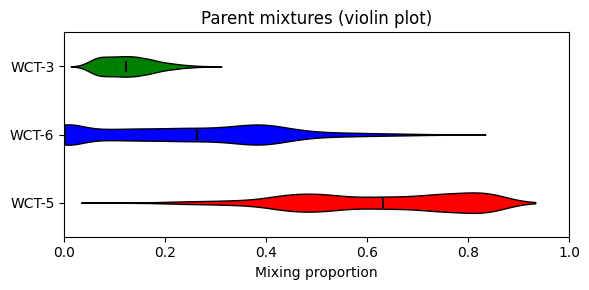

In [60]:
# Violin plots for CT-5 + CT-6 CT-3 to CT-9 excluding 0, 1 values
fig, ax, filtered_data = plot_mixing_violin_filtered('/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_ct-3_to_ct-9.csv',
    #best_fit_values=[],
    labels=['WCT-5', 'WCT-6', 'WCT-3'],
    colors=['red', 'blue', 'green'],
    title="Parent mixtures (violin plot)",
    save_path='Figures/violin_ct-5_ct-6_ct-3_to_ct-9_filtered.png')

### CT-5 + CT-6 + CT-3 to CT-2 analysis

In [62]:
# Call for CT-5 + CT-6 + CT-3 to CT-2  
csv_file = '/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Zircon/detritalPy_mix/Spreadsheets/mix_coeffs_all_ct-5_ct-6_ct-3_to_ct-2.csv'
results = calculate_zircon_fertility_ratios3_to_1(
    csv_filename=csv_file,
    sample_a_key='CT-5',
    sample_b_key='CT-6', 
    sample_c_key='CT-3',
    erosion_samples=erosion_samples,  # Your erosion samples dictionary
    df=df,  # Your dataframe with source area data
    wct_a=0.389710412987919,  # WCT_5 
    wct_b=0.438664445770773,  # WCT_6
    wct_c=0.171625141241309,  # WCT_3
    sample_a_index=4,  # Row index for CT-5 in dataframe
    sample_b_index=5,  # Row index for CT-6 in dataframe  
    sample_c_index=2,  # Row index for Canyon in dataframe (you'll need to set this)
    num_samples=10000,
    random_seed=17
)

print_fertility_results_3sample(results, 'CT-5', 'CT-6', 'CT-3')

Calculation parameters:
Number of valid coefficient sets after filtering: 4992
Source Areas - CT-5: 1495.897, CT-6: 2573.245, CT-3: 189.205
Mean erosion rates - CT-5: 386.6060, CT-6: 29.8388, CT-3: 29.4593
Mean mixing coefficients - CT-5: 0.3854, CT-6: 0.4868, CT-3: 0.1276
Random seed: 17, Number of samples: 10000

ZCT-5/ZCT-6/ZCT-3 Ratio Analysis based on Monte Carlo simulations

Individual Ratios (relative to total):
Median ZCT-5/ZD: 0.4563
Median ZCT-6/ZD: 4.0357
Median ZCT-3/ZD: 14.8833

Pairwise Ratio Medians:
(CT-5_CT-6) 0.1068
(CT-5_CT-3) 0.0293
(CT-6_CT-5) 9.3613
(CT-3_CT-5) 34.1410
(CT-3_CT-6) 3.6264

Fertility Ratios (median, (25-75% range)):
ZCT-6_ZCT-5 Fertility Ratio: 9.3613 (6.4416 - 13.9582)
ZCT-5_ZCT-6 Fertility Ratio: 0.1068 (0.0716 - 0.1552)
ZCT-5_ZCT-3 Fertility Ratio: 0.0293 (0.0198 - 0.0427)
ZCT-3_ZCT-5 Fertility Ratio: 34.1410 (23.4371 - 50.5405)
ZCT-6_ZCT-3 Fertility Ratio: 0.2758 (0.1910 - 0.4029)
ZCT-3_ZCT-6 Fertility Ratio: 3.6264 (2.4817 - 5.2354)
